In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm

In [2]:
import sklearn
import sklearn.metrics as metrics
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from scikitplot.metrics import plot_roc_curve, precision_recall_curve
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics.cluster import homogeneity_score
from itertools import product
from sklearn.cluster import MiniBatchKMeans
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
import random
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, silhouette_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
import scipy.stats as stats
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

In [3]:
df=pd.read_csv(r"C:\Users\conta\OneDrive\Desktop\General Assembly\Projects\project-capstone\Credit cards\CleanEDAfraud.csv")
df.head()

,category,amt,gender,city_pop,is_fraud,trans_day,trans_month,trans_hour,trans_year,age_at_trans,dist
0,misc_net,4.97,F,3495,0,Tuesday,January,0,2019,20-30,40-50
1,grocery_pos,107.23,F,149,0,Tuesday,January,0,2019,30-40,10-20
2,entertainment,220.11,M,4154,0,Tuesday,January,0,2019,50-60,60 - 70
3,gas_transport,45.00,M,1939,0,Tuesday,January,0,2019,50-60,50-60
4,misc_pos,41.96,M,99,0,Tuesday,January,0,2019,30-40,40-50


In [4]:
# Will work with sample to make process faster
df_sample=df.sample(frac=0.1, random_state=42)
df_sample.shape

(185239, 11)

In [5]:
#Checking percentage of fraud and non-fraud transactions
#Baseline is 0.994 non-fraud transactions
print("Original:", df.is_fraud.value_counts(normalize=True))
print("Sample:", df_sample.is_fraud.value_counts(normalize=True))

Original: 0    0.99479
1    0.00521
Name: is_fraud, dtype: float64
Sample: 0    0.994634
1    0.005366
Name: is_fraud, dtype: float64


In [6]:
# Creating dummy variables for Category

X1 = pd.get_dummies(df_sample, columns=['category', 'gender', 'trans_year', 'trans_day', 'trans_month', 'trans_hour', 'age_at_trans', 'dist'],drop_first=True)
y = X1.pop('is_fraud')

In [7]:
scaler=StandardScaler()
X=scaler.fit_transform(X1)

In [8]:
# Split your data X and y, into a training and a test set and fit the pipeline onto the training data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

### Logistic Regression
- Logistic Regression is one of the most used ML algorithms in binary classification
- Can be adjusted reasonably well to work on imbalanced data...useful for fraud detection

In [9]:
lr = LogisticRegression(random_state=42, solver='liblinear', penalty='l2')
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_train)
test_pred_lr = lr.predict(X_test)
print('Accuracy Train Score:', accuracy_score(y_train, pred_lr))
print('Accuracy Test Score:', accuracy_score(y_test, test_pred_lr))
print('5 Cross val score:', cross_val_score(lr, X_train, y_train, cv=5))
print('Cross val score:', cross_val_score(lr, X_train, y_train, cv=5).mean())

Accuracy Train Score: 0.99528792985108
Accuracy Test Score: 0.9952674008493486
5 Cross val score: [0.99541143 0.99529575 0.99537269 0.99533413 0.99494852]
Cross val score: 0.9952725044755351


In [10]:
print(f'Confusion Matrix:\n{confusion_matrix(y_train, pred_lr)}')
print(f'Classification Report:\n{ classification_report(y_train, pred_lr)}')

Confusion Matrix:
[[128927     44]
 [   567    129]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    128971
           1       0.75      0.19      0.30       696

    accuracy                           1.00    129667
   macro avg       0.87      0.59      0.65    129667
weighted avg       0.99      1.00      0.99    129667



In [11]:
print(f'Confusion Matrix:\n{confusion_matrix(y_test, test_pred_lr)}')
print(f'Classification Report:\n{ classification_report(y_test, test_pred_lr)}')

Confusion Matrix:
[[55263    11]
 [  252    46]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     55274
           1       0.81      0.15      0.26       298

    accuracy                           1.00     55572
   macro avg       0.90      0.58      0.63     55572
weighted avg       0.99      1.00      0.99     55572



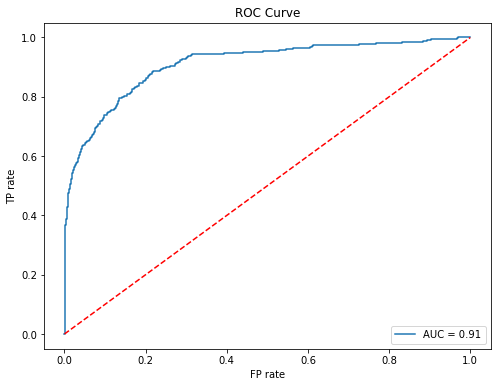

In [12]:
# Plotting Test ROC curve it measures the cost in terms of the false positive rate when the true positive rate increases.
y_pred = lr.predict_proba(X_test)[:,1]
fp_r, tp_r, t = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fp_r, tp_r)
plt.figure(figsize=(8, 6))
plt.plot(fp_r, tp_r, label="AUC = %.2f" % auc)
plt.plot([0,1],[0,1],"r--")
plt.ylabel("TP rate")
plt.xlabel("FP rate")
plt.legend(loc=4)
plt.title("ROC Curve")
plt.show()

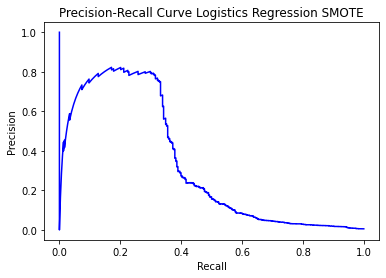

In [13]:
#Precision-recall curve shows the tradeoff between precision and recall for different thresholds.
#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='blue')

#add axis labels to plot
ax.set_title('Precision-Recall Curve Logistics Regression SMOTE')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()

###  On imbalance data Logictic Regression detected  252 fraud cases and accuracy score high.  The number of samples for class 1 is extremely less than 50% of the samples of class 0. In this case the the machine learning algorithms with not predict the Fraud cases correctly. To predict the Fraud correctly I will use a SMOTE method for oversampling minority class. This technique is followed to avoid overfitting such as ROS, which occurs when exact replicas of minority instances are added to the main dataset.  
### Random Under sampling aims to balance class distribution by randomly eliminating majority class examples. This is done until majority and minority class instances are balanced out. The sample chosen by random under-sampling may be a biased sample. And it therefore will not be an accurate representative of the population. 

In [9]:
# Apply SMOTE

sm = SMOTE(sampling_strategy='minority', random_state=42)
# Fit the model to generate the data.
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
print(f'Original dataset shape:\n{ y_train.value_counts()}')
print(f'Resample dataset shape:\n{ y_train_sm.value_counts()}')

Original dataset shape:
0    128971
1       696
Name: is_fraud, dtype: int64
Resample dataset shape:
1    128971
0    128971
Name: is_fraud, dtype: int64


In [10]:
#Apply RUS

rus = RandomUnderSampler(random_state=42, replacement=True)
# Fit the model to generate the data.
X_rus, y_rus = rus.fit_resample(X_train, y_train)

print(f'Original dataset shape:\n{ y_train.value_counts()}')
print(f'Resample dataset shape:\n{ y_rus.value_counts()}')

Original dataset shape:
0    128971
1       696
Name: is_fraud, dtype: int64
Resample dataset shape:
1    696
0    696
Name: is_fraud, dtype: int64


In [16]:
y_test.value_counts()

0    55274
1      298
Name: is_fraud, dtype: int64

In [17]:
X_test.shape

(55572, 72)

### Logistic Regression RUS

In [18]:
lr_rus = LogisticRegression(random_state=42, solver='liblinear', penalty='l2')
lr_rus.fit(X_rus, y_rus)
pred_lr_r = lr_rus.predict(X_rus)
test_pred_lr_r = lr_rus.predict(X_test)
print('Accuracy Train Score:', accuracy_score(y_rus, pred_lr_r))
print('Accuracy Test Score:', accuracy_score(y_test, test_pred_lr_r))
print('5 Cross val score:', cross_val_score(lr_rus, X_rus, y_rus, cv=5))
print('Cross val score:', cross_val_score(lr_rus, X_rus, y_rus, cv=5).mean())

Accuracy Train Score: 0.9087643678160919
Accuracy Test Score: 0.8842942489023249
5 Cross val score: [0.88172043 0.90322581 0.89208633 0.88129496 0.88129496]
Cross val score: 0.8879244991103891


In [19]:
print(f'Confusion Matrix:\n{confusion_matrix(y_rus, pred_lr_r)}')
print(f'Classification Report:\n{ classification_report(y_rus, pred_lr_r)}')

Confusion Matrix:
[[632  64]
 [ 63 633]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       696
           1       0.91      0.91      0.91       696

    accuracy                           0.91      1392
   macro avg       0.91      0.91      0.91      1392
weighted avg       0.91      0.91      0.91      1392



In [20]:
print(f'Confusion Matrix:\n{confusion_matrix(y_test, test_pred_lr_r)}')
print(f'Classification Report:\n{classification_report(y_test, test_pred_lr_r)}')

Confusion Matrix:
[[48885  6389]
 [   41   257]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.88      0.94     55274
           1       0.04      0.86      0.07       298

    accuracy                           0.88     55572
   macro avg       0.52      0.87      0.51     55572
weighted avg       0.99      0.88      0.93     55572



- ### Precision: Correct positive predictions relative to total positive predictions. In fraud detection, a false positive means that a transaction that is non fraud  has been identified as fraud. The  credit card might be blocked at the transaction.  
- ### Recall: Correct positive predictions relative to total actual positives if a fraudulent transaction  is predicted as non-fraudulent , the consequence can be very bad for the bank.  
- ### F1 Score is needed when you want to seek a balance between Precision and Recall. F1 Score might be a better measure to use if we need to seek a balance between Precision and Recall and there is an uneven class distribution (large number of Actual Negatives).


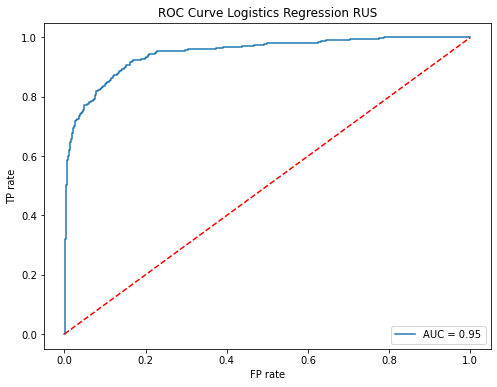

In [21]:
# Plotting Test ROC curve it measures the cost in terms of the false positive rate when the true positive rate increases.
y_pred_r = lr_rus.predict_proba(X_test)[:,1]
fp_r, tp_r, t = metrics.roc_curve(y_test, y_pred_r)
auc_r = metrics.auc(fp_r, tp_r)
plt.figure(figsize=(8, 6))
plt.plot(fp_r, tp_r, label="AUC = %.2f" % auc_r)
plt.plot([0,1],[0,1],"r--")
plt.ylabel("TP rate")
plt.xlabel("FP rate")
plt.legend(loc=4)
plt.title("ROC Curve Logistics Regression RUS")
plt.show()

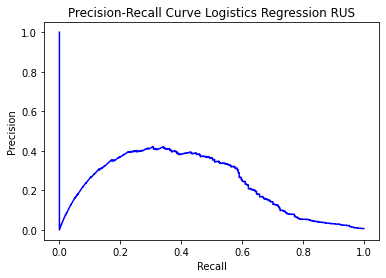

In [22]:
#Precision-recall curve shows the tradeoff between precision and recall for different thresholds.
#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_r)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='blue')

#add axis labels to plot
ax.set_title('Precision-Recall Curve Logistics Regression RUS')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()

### SMOTE LOGICTIC REGRESSION

In [23]:
lr_s = LogisticRegression(random_state=42, solver='liblinear', penalty='l2')
lr_s.fit(X_train_sm, y_train_sm)
pred_lr_s = lr_s.predict(X_train_sm)
test_pred_lr_s = lr_s.predict(X_test)
print('Accuracy Train Score:', accuracy_score(y_train_sm, pred_lr_s))
print('Accuracy Test Score:', accuracy_score(y_test, test_pred_lr_s))
print('5 Cross val score:', cross_val_score(lr_s, X_train_sm, y_train_sm, cv=5))
print('Cross val score:', cross_val_score(lr_s, X_train_sm, y_train_sm, cv=5).mean())

Accuracy Train Score: 0.9189585255600096
Accuracy Test Score: 0.9018030662923775
5 Cross val score: [0.91783132 0.9212429  0.91773281 0.91872141 0.91914786]
Cross val score: 0.9189352598502705


In [24]:
print(f'Confusion Matrix:\n{confusion_matrix(y_train_sm, pred_lr_s)}')
print(f'Classification Report:\n{ classification_report(y_train_sm, pred_lr_s)}')

Confusion Matrix:
[[116362  12609]
 [  8295 120676]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.90      0.92    128971
           1       0.91      0.94      0.92    128971

    accuracy                           0.92    257942
   macro avg       0.92      0.92      0.92    257942
weighted avg       0.92      0.92      0.92    257942



In [25]:
print(f'Confusion Matrix:\n{confusion_matrix(y_test, test_pred_lr_s)}')
print(f'Classification Report:\n{ classification_report(y_test, test_pred_lr_s)}')

Confusion Matrix:
[[49862  5412]
 [   45   253]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95     55274
           1       0.04      0.85      0.08       298

    accuracy                           0.90     55572
   macro avg       0.52      0.88      0.52     55572
weighted avg       0.99      0.90      0.94     55572



### With Logistic Regression(SMOTE) , 253 out of 298 fraud cases are detected, 45 fraud are not detected, and 5412  are identified as fraud but it's not. F1 score 0.08

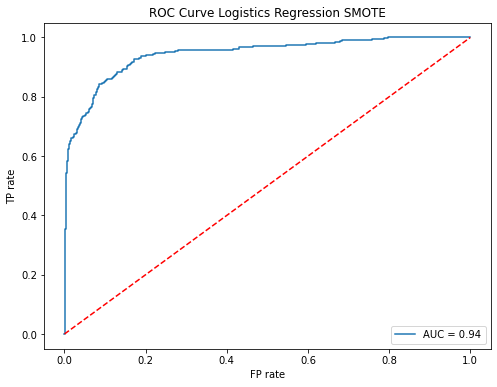

In [26]:
# Plotting Test ROC curve it measures the cost in terms of the false positive rate when the true positive rate increases.
y_pred_s = lr_s.predict_proba(X_test)[:,1]
fp_r, tp_r, t = metrics.roc_curve(y_test, y_pred_s)
auc_s = metrics.auc(fp_r, tp_r)
plt.figure(figsize=(8, 6))
plt.plot(fp_r, tp_r, label="AUC = %.2f" % auc_s)
plt.plot([0,1],[0,1],"r--")
plt.ylabel("TP rate")
plt.xlabel("FP rate")
plt.legend(loc=4)
plt.title("ROC Curve Logistics Regression SMOTE")
plt.show()

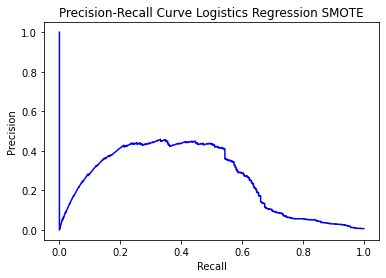

In [27]:
#Precision-recall curve shows the tradeoff between precision and recall for different thresholds.
#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_s)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='blue')

#add axis labels to plot
ax.set_title('Precision-Recall Curve Logistics Regression SMOTE')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()

### DecisionTreeClassifier 
- Commonly used for fraud detection
- Decision trees are prone to overfit the data

In [28]:
# DTC on imbalance data
dtc = DecisionTreeClassifier(criterion = 'gini', max_depth = 20, random_state=42)
dtc.fit(X_train, y_train)
pred_dtc = dtc.predict(X_train)
pred_dtc_test = dtc.predict(X_test)
print('Accuracy Train Score:', accuracy_score(y_train, pred_dtc))
print('Accuracy Test Score:', accuracy_score(y_test, pred_dtc_test))
print('5 Cross val score:', cross_val_score(dtc, X_train, y_train, cv=5))
print('Cross val score:', cross_val_score(dtc, X_train, y_train, cv=5).mean())

Accuracy Train Score: 1.0
Accuracy Test Score: 0.996527027999712
5 Cross val score: [0.99695381 0.99656821 0.99660664 0.99703081 0.99622103]
Cross val score: 0.9966760997800683


In [29]:
print(f'Confusion Matrix:\n{confusion_matrix(y_train, pred_dtc)}')
print(f'Classification Report:\n{ classification_report(y_train, pred_dtc)}')

Confusion Matrix:
[[128971      0]
 [     0    696]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    128971
           1       1.00      1.00      1.00       696

    accuracy                           1.00    129667
   macro avg       1.00      1.00      1.00    129667
weighted avg       1.00      1.00      1.00    129667



In [30]:
print(f'Confusion Matrix:\n{confusion_matrix(y_test, pred_dtc_test)}')
print(f'Classification Report:\n{classification_report(y_test, pred_dtc_test)}')

Confusion Matrix:
[[55170   104]
 [   89   209]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     55274
           1       0.67      0.70      0.68       298

    accuracy                           1.00     55572
   macro avg       0.83      0.85      0.84     55572
weighted avg       1.00      1.00      1.00     55572



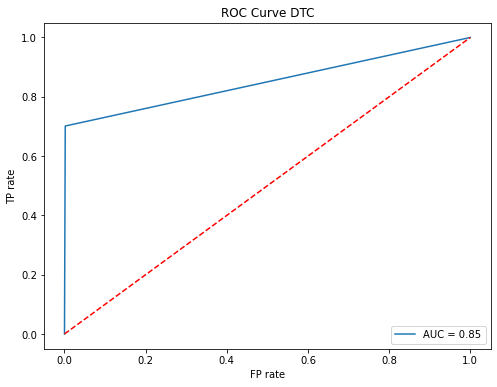

In [31]:
y_pred_d = dtc.predict_proba(X_test)[:,1]
fp_r, tp_r, t = metrics.roc_curve(y_test, y_pred_d)
auc_d = metrics.auc(fp_r, tp_r)
plt.figure(figsize=(8, 6))
plt.plot(fp_r, tp_r, label="AUC = %.2f" % auc_d)
plt.plot([0,1],[0,1],"r--")
plt.ylabel("TP rate")
plt.xlabel("FP rate")
plt.legend(loc=4)
plt.title("ROC Curve DTC")
plt.show()

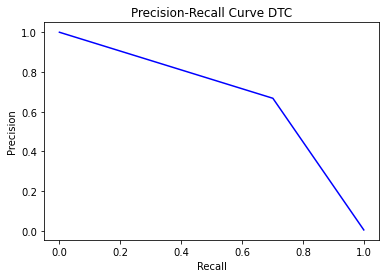

In [32]:
#Precision-recall curve shows the tradeoff between precision and recall for different thresholds.
#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_d)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='blue')

#add axis labels to plot
ax.set_title('Precision-Recall Curve DTC')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()

### Decision Tree with Random Under Sample Method

In [33]:
# DTC RUS
dtc_r = DecisionTreeClassifier(criterion = 'gini', max_depth = 20, random_state=42)
dtc_r.fit(X_rus, y_rus)
pred_dtc_r = dtc_r.predict(X_rus)
pred_dtc_test_r = dtc_r.predict(X_test)
print('Accuracy Train Score:', accuracy_score(y_rus, pred_dtc_r))
print('Accuracy Test Score:', accuracy_score(y_test, pred_dtc_test_r))
print('5 Cross val score:', cross_val_score(dtc_r, X_rus, y_rus, cv=5))
print('Cross val score:', cross_val_score(dtc_r, X_rus, y_rus, cv=5).mean())

Accuracy Train Score: 1.0
Accuracy Test Score: 0.9294968689267976
5 Cross val score: [0.91756272 0.94623656 0.9352518  0.94604317 0.95323741]
Cross val score: 0.9396663314509682


In [34]:
print(f'Confusion Matrix:\n{confusion_matrix(y_rus, pred_dtc_r)}')
print(f'Classification Report:\n{ classification_report(y_rus, pred_dtc_r)}')

Confusion Matrix:
[[696   0]
 [  0 696]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       696
           1       1.00      1.00      1.00       696

    accuracy                           1.00      1392
   macro avg       1.00      1.00      1.00      1392
weighted avg       1.00      1.00      1.00      1392



In [35]:
print(f'Confusion Matrix:\n{confusion_matrix(y_test, pred_dtc_test_r)}')
print(f'Classification Report:\n{classification_report(y_test, pred_dtc_test_r)}')

Confusion Matrix:
[[51378  3896]
 [   22   276]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     55274
           1       0.07      0.93      0.12       298

    accuracy                           0.93     55572
   macro avg       0.53      0.93      0.54     55572
weighted avg       0.99      0.93      0.96     55572



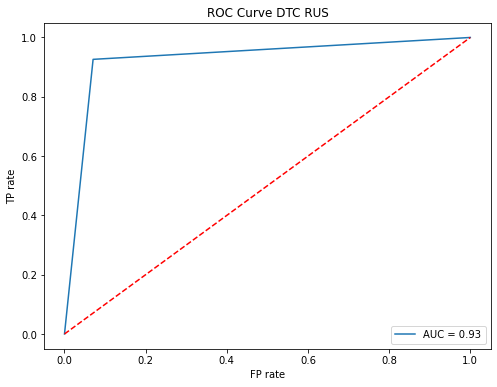

In [36]:
y_pred_d_r = dtc_r.predict_proba(X_test)[:,1]
fp_r, tp_r, t = metrics.roc_curve(y_test, y_pred_d_r)
auc_d_r = metrics.auc(fp_r, tp_r)
plt.figure(figsize=(8, 6))
plt.plot(fp_r, tp_r, label="AUC = %.2f" % auc_d_r)
plt.plot([0,1],[0,1],"r--")
plt.ylabel("TP rate")
plt.xlabel("FP rate")
plt.legend(loc=4)
plt.title("ROC Curve DTC RUS")
plt.show()

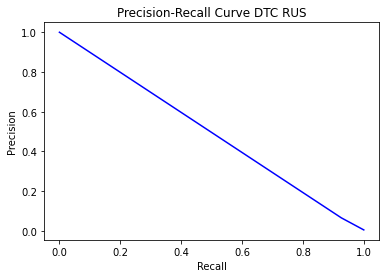

In [37]:
#Precision-recall curve shows the tradeoff between precision and recall for different thresholds.
#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_d_r)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='blue')

#add axis labels to plot
ax.set_title('Precision-Recall Curve DTC RUS')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()

### Decision Tree with SMOTE Method

In [38]:
# DTC SMOTE
dtc_s = DecisionTreeClassifier(criterion = 'gini', max_depth = 20, random_state=42)
dtc_s.fit(X_train_sm, y_train_sm)
pred_dtc_s = dtc_s.predict(X_train_sm)
pred_dtc_test_s = dtc.predict(X_test)
print('Accuracy Train Score:', accuracy_score(y_train_sm, pred_dtc_s))
print('Accuracy Test Score:', accuracy_score(y_test, pred_dtc_test_s))
print('5 Cross val score:', cross_val_score(dtc_s, X_train_sm, y_train_sm, cv=5))
print('Cross val score:', cross_val_score(dtc_s, X_train_sm, y_train_sm, cv=5).mean())

Accuracy Train Score: 0.9966775476657543
Accuracy Test Score: 0.996527027999712
5 Cross val score: [0.99371959 0.99538661 0.99496007 0.99523145 0.99536714]
Cross val score: 0.9949329723726261


In [39]:
print(f'Confusion Matrix:\n{confusion_matrix(y_train_sm, pred_dtc_s)}')
print(f'Classification Report:\n{ classification_report(y_train_sm, pred_dtc_s)}')

Confusion Matrix:
[[128117    854]
 [     3 128968]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    128971
           1       0.99      1.00      1.00    128971

    accuracy                           1.00    257942
   macro avg       1.00      1.00      1.00    257942
weighted avg       1.00      1.00      1.00    257942



In [40]:
print(f'Confusion Matrix:\n{confusion_matrix(y_test, pred_dtc_test_s)}')
print(f'Classification Report:\n{classification_report(y_test, pred_dtc_test_s)}')

Confusion Matrix:
[[55170   104]
 [   89   209]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     55274
           1       0.67      0.70      0.68       298

    accuracy                           1.00     55572
   macro avg       0.83      0.85      0.84     55572
weighted avg       1.00      1.00      1.00     55572



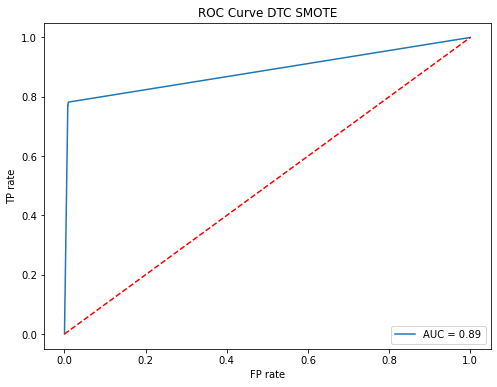

In [41]:
y_pred_d_s = dtc_s.predict_proba(X_test)[:,1]
fp_r, tp_r, t = metrics.roc_curve(y_test, y_pred_d_s)
auc_d_s = metrics.auc(fp_r, tp_r)
plt.figure(figsize=(8, 6))
plt.plot(fp_r, tp_r, label="AUC = %.2f" % auc_d_s)
plt.plot([0,1],[0,1],"r--")
plt.ylabel("TP rate")
plt.xlabel("FP rate")
plt.legend(loc=4)
plt.title("ROC Curve DTC SMOTE")
plt.show()

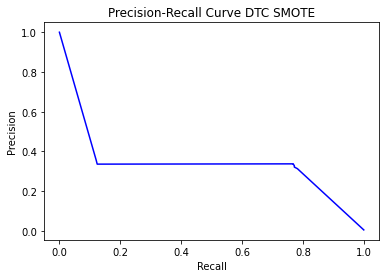

In [42]:
#Precision-recall curve shows the tradeoff between precision and recall for different thresholds.
#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_d_s)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='blue')

#add axis labels to plot
ax.set_title('Precision-Recall Curve DTC SMOTE')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()

### Random Forests are a more robust option than a single decision tree
- Construct a multitude of decision trees when training the model and outputting the class that is the mode or mean predicted -- class of the individual trees
- A random forest consists of a collection of trees on a random subset of features
- Final predictions are the combined results of those trees
- Random forests can handle complex data and are not prone to overfit
- They are interpretable by looking at feature importance, and can be adjusted to work well on highly imbalanced data
- Their drawback is they're computationally complex
- Very popular for fraud detection

### Random Forest on imbalance data just to see the difference

In [43]:
# RFC
rfc = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=5, max_features=12,
                             min_samples_leaf=100, random_state=100)
rfc.fit(X_train, y_train)
pred_rfc = rfc.predict(X_train)
pred_rfc_test = rfc.predict(X_test)
print('Accuracy Train Score:', accuracy_score(y_train, pred_rfc))
print('Accuracy Test Score:', accuracy_score(y_test, pred_rfc_test))
print('5 Cross val score:', cross_val_score(rfc, X_train, y_train, cv=5))
print('Cross val score:', cross_val_score(rfc, X_train, y_train, cv=5).mean())

Accuracy Train Score: 0.9946324045439472
Accuracy Test Score: 0.9946375872741668
5 Cross val score: [0.99464024 0.99460168 0.99464003 0.99464003 0.99464003]
Cross val score: 0.994632404720458


In [44]:
print(f'Confusion Matrix:\n{confusion_matrix(y_train, pred_rfc)}')
print(f'Classification Report:\n{ classification_report(y_train, pred_rfc)}')

Confusion Matrix:
[[128971      0]
 [   696      0]]


C:\Users\conta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    128971
           1       0.00      0.00      0.00       696

    accuracy                           0.99    129667
   macro avg       0.50      0.50      0.50    129667
weighted avg       0.99      0.99      0.99    129667



In [45]:
print(f'Confusion Matrix:\n{confusion_matrix(y_test, pred_rfc_test)}')
print(f'Classification Report:\n{classification_report(y_test, pred_rfc_test)}')

Confusion Matrix:
[[55274     0]
 [  298     0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     55274
           1       0.00      0.00      0.00       298

    accuracy                           0.99     55572
   macro avg       0.50      0.50      0.50     55572
weighted avg       0.99      0.99      0.99     55572



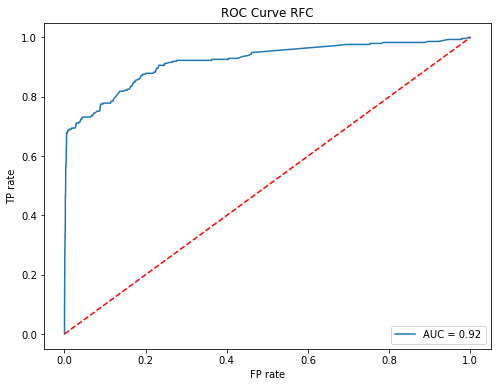

In [46]:
y_pred_rfc = rfc.predict_proba(X_test)[:,1]
fp_r, tp_r, t = metrics.roc_curve(y_test, y_pred_rfc)
auc_rfc = metrics.auc(fp_r, tp_r)
plt.figure(figsize=(8, 6))
plt.plot(fp_r, tp_r, label="AUC = %.2f" % auc_rfc)
plt.plot([0,1],[0,1],"r--")
plt.ylabel("TP rate")
plt.xlabel("FP rate")
plt.legend(loc=4)
plt.title("ROC Curve RFC")
plt.show()

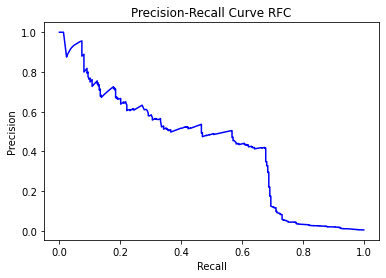

In [47]:
#Precision-recall curve shows the tradeoff between precision and recall for different thresholds.
#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_rfc)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='blue')

#add axis labels to plot
ax.set_title('Precision-Recall Curve RFC')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()

### Random Forest with RUS

In [48]:
#Building a Random Forest Model
rfc_r = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=5, max_features=12,
                               min_samples_leaf=100, random_state=100)
rfc_r.fit(X_rus, y_rus)
pred_rfc_r = rfc_r.predict(X_rus)
pred_rfc_test_r = rfc_r.predict(X_test)
print('Accuracy Train Score:', accuracy_score(y_rus, pred_rfc_r))
print('Accuracy Test Score:', accuracy_score(y_test, pred_rfc_test_r))
print('5 Cross val score:', cross_val_score(rfc_r, X_rus, y_rus, cv=5))
print('Cross val score:', cross_val_score(rfc_r, X_rus, y_rus, cv=5).mean())

Accuracy Train Score: 0.8433908045977011
Accuracy Test Score: 0.8989779025408479
5 Cross val score: [0.83154122 0.85304659 0.84892086 0.83453237 0.83453237]
Cross val score: 0.8405146850261727


In [49]:
print(f'Confusion Matrix:\n{confusion_matrix(y_rus, pred_rfc_r)}')
print(f'Classification Report:\n{ classification_report(y_rus, pred_rfc_r)}')

Confusion Matrix:
[[631  65]
 [153 543]]
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.91      0.85       696
           1       0.89      0.78      0.83       696

    accuracy                           0.84      1392
   macro avg       0.85      0.84      0.84      1392
weighted avg       0.85      0.84      0.84      1392



In [50]:
print(f'Confusion Matrix:\n{confusion_matrix(y_test, pred_rfc_test_r)}')
print(f'Classification Report:\n{classification_report(y_test, pred_rfc_test_r)}')

Confusion Matrix:
[[49738  5536]
 [   78   220]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95     55274
           1       0.04      0.74      0.07       298

    accuracy                           0.90     55572
   macro avg       0.52      0.82      0.51     55572
weighted avg       0.99      0.90      0.94     55572



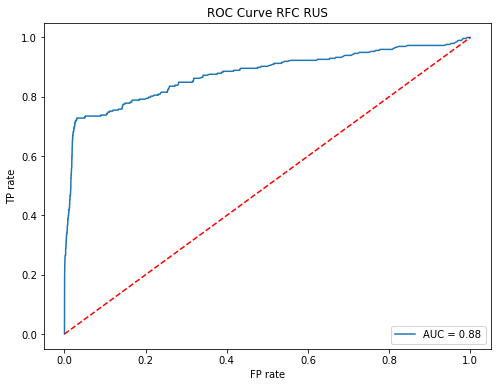

In [51]:
y_pred_rfc_r = rfc_r.predict_proba(X_test)[:,1]
fp_r, tp_r, t = metrics.roc_curve(y_test, y_pred_rfc_r)
auc_rfc_r = metrics.auc(fp_r, tp_r)
plt.figure(figsize=(8, 6))
plt.plot(fp_r, tp_r, label="AUC = %.2f" % auc_rfc_r)
plt.plot([0,1],[0,1],"r--")
plt.ylabel("TP rate")
plt.xlabel("FP rate")
plt.legend(loc=4)
plt.title("ROC Curve RFC RUS")
plt.show()

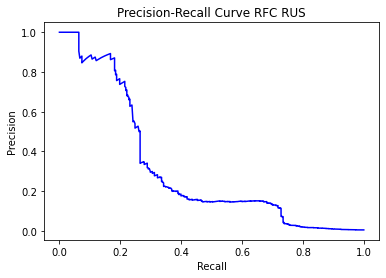

In [52]:
#Precision-recall curve shows the tradeoff between precision and recall for different thresholds.
#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_rfc_r)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='blue')

#add axis labels to plot
ax.set_title('Precision-Recall Curve RFC RUS')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()

### RFC with SMOTE

In [53]:
#Building a Random Forest Model
rfc_s = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=5, max_features=12, min_samples_leaf=100, random_state=100)
rfc_s.fit(X_train_sm, y_train_sm)
pred_rfc_s = rfc_s.predict(X_train_sm)
pred_rfc_test_s = rfc_s.predict(X_test)
print('Accuracy Train Score:', accuracy_score(y_train_sm, pred_rfc_s))
print('Accuracy Test Score:', accuracy_score(y_test, pred_rfc_test_s))
print('5 Cross val score:', cross_val_score(rfc_s, X_train_sm, y_train_sm, cv=5))
print('Cross val score:', cross_val_score(rfc_s, X_train_sm, y_train_sm, cv=5).mean())

Accuracy Train Score: 0.9213737972102256
Accuracy Test Score: 0.975005398402073
5 Cross val score: [0.9251197  0.92820175 0.92575793 0.92236567 0.92319919]
Cross val score: 0.9249288465478619


In [54]:
print(f'Confusion Matrix:\n{confusion_matrix(y_train_sm, pred_rfc_s)}')
print(f'Classification Report:\n{ classification_report(y_train_sm, pred_rfc_s)}')

Confusion Matrix:
[[126093   2878]
 [ 17403 111568]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.98      0.93    128971
           1       0.97      0.87      0.92    128971

    accuracy                           0.92    257942
   macro avg       0.93      0.92      0.92    257942
weighted avg       0.93      0.92      0.92    257942



In [55]:
print(f'Confusion Matrix:\n{confusion_matrix(y_test, pred_rfc_test_s)}')
print(f'Classification Report:\n{classification_report(y_test, pred_rfc_test_s)}')

Confusion Matrix:
[[53969  1305]
 [   84   214]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     55274
           1       0.14      0.72      0.24       298

    accuracy                           0.98     55572
   macro avg       0.57      0.85      0.61     55572
weighted avg       0.99      0.98      0.98     55572



### With RFC SMOTE, 214 out of 298 fraud cases are detected,  84 are not detected, and 1,305 false positives are identified. F1 score 0.24


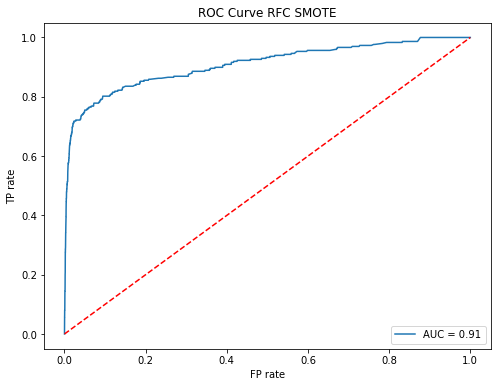

In [56]:
y_pred_rfc_s = rfc_s.predict_proba(X_test)[:,1]
fp_r, tp_r, t = metrics.roc_curve(y_test, y_pred_rfc_s)
auc_rfc_s = metrics.auc(fp_r, tp_r)
plt.figure(figsize=(8, 6))
plt.plot(fp_r, tp_r, label="AUC = %.2f" % auc_rfc_s)
plt.plot([0,1],[0,1],"r--")
plt.ylabel("TP rate")
plt.xlabel("FP rate")
plt.legend(loc=4)
plt.title("ROC Curve RFC SMOTE")
plt.show()

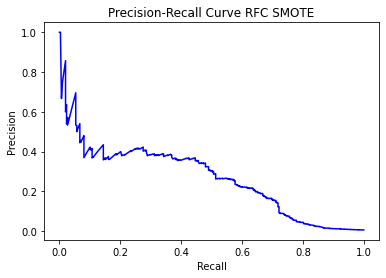

In [57]:
#Precision-recall curve shows the tradeoff between precision and recall for different thresholds.
#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_rfc_s)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='blue')

#add axis labels to plot
ax.set_title('Precision-Recall Curve RFC SMOTE')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()

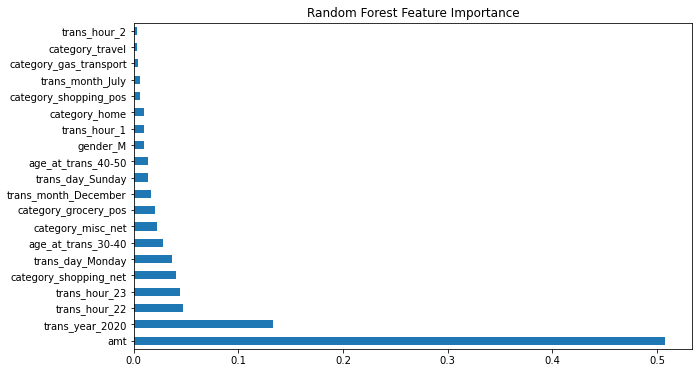

In [58]:
# Show the features importance
plt.figure(figsize=(10,6))
rfc_f_importances = pd.Series(rfc_s.feature_importances_, index=X1.columns)
rfc_f_importances.nlargest(20).plot(kind='barh')
plt.title("Random Forest Feature Importance");


### RFC Grid Search with SMOTE

In [59]:
def rfc_search(X_train_sm,y_train_sm, search_verbose=1):
    params = {'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]}
    
    rfc = RandomForestClassifier()

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    grid_search = GridSearchCV(estimator=rfc, param_grid=params, scoring="roc_auc", 
                               n_jobs=1, cv=skf.split(X_train_sm,y_train_sm), verbose=search_verbose)

    grid_search.fit(X_train_sm,y_train_sm)

    
    print(f'Best estimator:\n{grid_search.best_estimator_}')
    print("Parameters: ", grid_search.best_params_)
    print("Highest AUC: %.2f" % grid_search.best_score_)

    return grid_search.best_params_

In [60]:
model_params = rfc_search(X_train_sm, y_train_sm)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 864 out of 864 | elapsed: 787.3min finished


Best estimator:
RandomForestClassifier(max_depth=80, max_features=3, min_samples_leaf=3,
                       min_samples_split=12, n_estimators=1000)
Parameters:  {'bootstrap': True, 'max_depth': 80, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 12, 'n_estimators': 1000}
Highest AUC: 1.00


In [61]:
rfc_b_s = RandomForestClassifier()
rfc_b_s.set_params(**model_params)
rfc_b_s.fit(X_train_sm, y_train_sm)

RandomForestClassifier(max_depth=80, max_features=3, min_samples_leaf=3,
                       min_samples_split=12, n_estimators=1000)

In [62]:
pred_rfc_b_s = rfc_b_s.predict(X_train_sm)
pred_rfc_test_b_s = rfc_b_s.predict(X_test)
print('Accuracy Train Score:', accuracy_score(y_train_sm, pred_rfc_b_s))
print('Accuracy Test Score:', accuracy_score(y_test, pred_rfc_test_b_s))
print('5 Cross val score:', cross_val_score(rfc_b_s, X_train_sm, y_train_sm, cv=5))
print('Cross val score:', cross_val_score(rfc_b_s, X_train_sm, y_train_sm, cv=5).mean())

Accuracy Train Score: 0.9992091245318715
Accuracy Test Score: 0.996527027999712
5 Cross val score: [0.99519277 0.99992246 0.99978677 0.99986431 0.99982554]
Cross val score: 0.9989493867070882


In [63]:
print(f'Confusion Matrix:\n{confusion_matrix(y_train_sm, pred_rfc_b_s)}')
print(f'Classification Report:\n{ classification_report(y_train_sm, pred_rfc_b_s)}')

Confusion Matrix:
[[128967      4]
 [   200 128771]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    128971
           1       1.00      1.00      1.00    128971

    accuracy                           1.00    257942
   macro avg       1.00      1.00      1.00    257942
weighted avg       1.00      1.00      1.00    257942



In [64]:
print(f'Confusion Matrix:\n{confusion_matrix(y_test, pred_rfc_test_b_s)}')
print(f'Classification Report:\n{ classification_report(y_test, pred_rfc_test_b_s)}')

Confusion Matrix:
[[55268     6]
 [  187   111]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     55274
           1       0.95      0.37      0.53       298

    accuracy                           1.00     55572
   macro avg       0.97      0.69      0.77     55572
weighted avg       1.00      1.00      1.00     55572



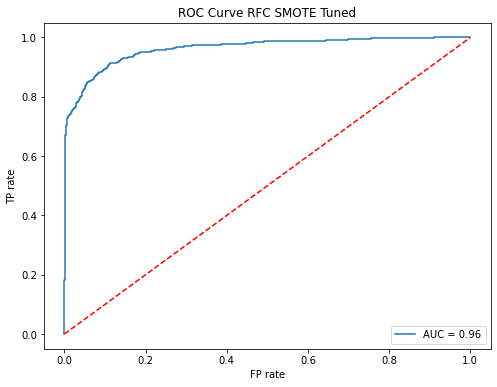

In [65]:
y_pred_r_b_s = rfc_b_s.predict_proba(X_test)[:,1]
fp_r, tp_r, t = metrics.roc_curve(y_test, y_pred_r_b_s)
auc_r_b_s = metrics.auc(fp_r, tp_r)
plt.figure(figsize=(8, 6))
plt.plot(fp_r, tp_r, label="AUC = %.2f" % auc_r_b_s)
plt.plot([0,1],[0,1],"r--")
plt.ylabel("TP rate")
plt.xlabel("FP rate")
plt.legend(loc=4)
plt.title("ROC Curve RFC SMOTE Tuned")
plt.show()

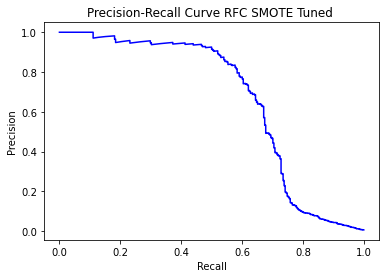

In [66]:
#Precision-recall curve shows the tradeoff between precision and recall for different thresholds.
#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_r_b_s)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='blue')

#add axis labels to plot
ax.set_title('Precision-Recall Curve RFC SMOTE Tuned ')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()

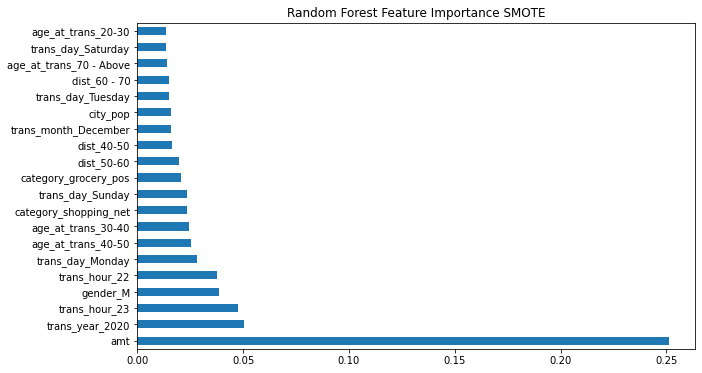

In [67]:
# Show the features importance
plt.figure(figsize=(10,6))
rfc_f_importances = pd.Series(rfc_b_s.feature_importances_, index=X1.columns)
rfc_f_importances.nlargest(20).plot(kind='barh')
plt.title("Random Forest Feature Importance SMOTE");

### To search best parameters for Random Forest  and XGBoost i will use Random under sampling method It will help me  improve run time by reducing the number of training data samples, but it can discard potentially useful information which could be important for building rule classifiers. The sample chosen by random under-sampling may be a biased sample. And it will not be an accurate representation of the population. 

### RFC Grid Search RUS

In [68]:
def rfc_search(X_rus,y_rus, search_verbose=1):
    params = {'bootstrap': [True, False],
              'max_depth': [10, 20, 30, 40, 50, 60, None],
              'max_features': ['auto', 'sqrt'],
              'min_samples_leaf': [1, 2, 4],
              'min_samples_split': [2, 5, 10],
              'n_estimators': [200, 400, 600, 800, 1000]}
    
    rfc = RandomForestClassifier()

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    grid_search = GridSearchCV(estimator=rfc, param_grid=params, scoring="roc_auc", 
                               n_jobs=1, cv=skf.split(X_rus, y_rus), verbose=search_verbose)

    grid_search.fit(X_rus,y_rus)

    
    print(f'Best estimator:\n{grid_search.best_estimator_}')
    print("Parameters: ", grid_search.best_params_)
    print("Highest AUC: %.2f" % grid_search.best_score_)

    return grid_search.best_params_

In [69]:
model_params = rfc_search(X_rus, y_rus)

Fitting 3 folds for each of 1260 candidates, totalling 3780 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3780 out of 3780 | elapsed: 58.2min finished


Best estimator:
RandomForestClassifier(bootstrap=False, max_depth=60, max_features='sqrt',
                       n_estimators=600)
Parameters:  {'bootstrap': False, 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 600}
Highest AUC: 0.99


In [70]:
rfc_b_r = RandomForestClassifier()
rfc_b_r.set_params(**model_params)
rfc_b_r.fit(X_rus, y_rus)

RandomForestClassifier(bootstrap=False, max_depth=60, max_features='sqrt',
                       n_estimators=600)

In [71]:
pred_rfc_b_r = rfc_b_r.predict(X_rus)
pred_rfc_test_b_r = rfc_b_r.predict(X_test)
print('Accuracy Train Score:', accuracy_score(y_rus, pred_rfc_b_r))
print('Accuracy Test Score:', accuracy_score(y_test, pred_rfc_test_b_r))
print('5 Cross val score:', cross_val_score(rfc_b_r, X_rus, y_rus, cv=5))
print('Cross val score:', cross_val_score(rfc_b_r, X_rus, y_rus, cv=5).mean())

Accuracy Train Score: 1.0
Accuracy Test Score: 0.9547973799755273
5 Cross val score: [0.94623656 0.95698925 0.95323741 0.94964029 0.94244604]
Cross val score: 0.9497073309094659


In [72]:
print(f'Confusion Matrix:\n{confusion_matrix(y_rus, pred_rfc_b_r)}')
print(f'Classification Report:\n{ classification_report(y_rus, pred_rfc_b_r)}')

Confusion Matrix:
[[696   0]
 [  0 696]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       696
           1       1.00      1.00      1.00       696

    accuracy                           1.00      1392
   macro avg       1.00      1.00      1.00      1392
weighted avg       1.00      1.00      1.00      1392



In [73]:
print(f'Confusion Matrix:\n{confusion_matrix(y_test, pred_rfc_test_b_r)}')
print(f'Classification Report:\n{ classification_report(y_test, pred_rfc_test_b_r)}')

Confusion Matrix:
[[52784  2490]
 [   22   276]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.98     55274
           1       0.10      0.93      0.18       298

    accuracy                           0.95     55572
   macro avg       0.55      0.94      0.58     55572
weighted avg       0.99      0.95      0.97     55572



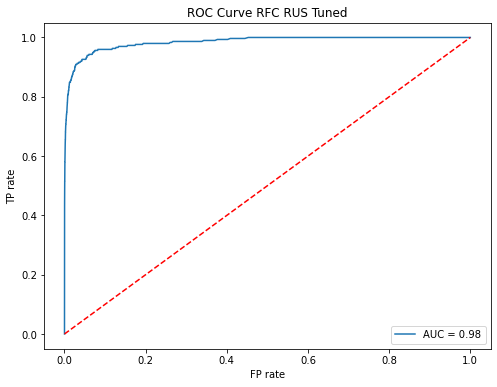

In [74]:
y_pred_r_b_r = rfc_b_r.predict_proba(X_test)[:,1]
fp_r, tp_r, t = metrics.roc_curve(y_test, y_pred_r_b_r)
auc_r_b_r = metrics.auc(fp_r, tp_r)
plt.figure(figsize=(8, 6))
plt.plot(fp_r, tp_r, label="AUC = %.2f" % auc_r_b_r)
plt.plot([0,1],[0,1],"r--")
plt.ylabel("TP rate")
plt.xlabel("FP rate")
plt.legend(loc=4)
plt.title("ROC Curve RFC RUS Tuned")
plt.show()

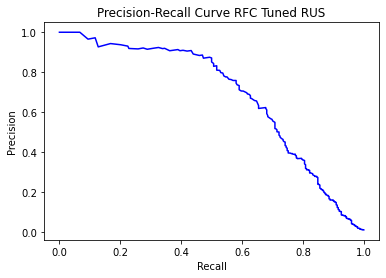

In [75]:
#Precision-recall curve shows the tradeoff between precision and recall for different thresholds.
#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_r_b_r)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='blue')

#add axis labels to plot
ax.set_title('Precision-Recall Curve RFC Tuned RUS')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()

### XGBoost Grid Search SMOTE

In [11]:
def xgboost_search(X_train_sm,y_train_sm, search_verbose=1):
    params = {
    "gamma":[0.5, 1, 1.5, 2, 5],
    "max_depth":[3,4,5,6],
    "min_child_weight": [100],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "learning_rate": [0.1, 0.01, 0.001]
    }
    xgb = XGBClassifier(objective="binary:logistic", eval_metric="auc", use_label_encoder=False)

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    grid_search = GridSearchCV(estimator=xgb, param_grid=params, scoring="roc_auc", n_jobs=1, 
                               cv=skf.split(X_train_sm,y_train_sm), verbose=search_verbose)

    grid_search.fit(X_train_sm,y_train_sm)

    print(f'Best estimator:\n{grid_search.best_estimator_}')
    print("Parameters: ", grid_search.best_params_)
    print("Highest AUC: %.2f" % grid_search.best_score_)

    return grid_search.best_params_

In [12]:
from sklearn.model_selection import StratifiedKFold
import random
#rows = random.sample(np.arange(0,len(X_rus.index)).tolist(), 5000)
model_params = xgboost_search(X_train_sm, y_train_sm)

Fitting 3 folds for each of 540 candidates, totalling 1620 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1620 out of 1620 | elapsed: 476.8min finished


Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, eval_metric='auc', gamma=1, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=100, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1.0, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)
Parameters:  {'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 100, 'subsample': 1.0}
Highest AUC: 1.00


In [13]:
xgb_s = XGBClassifier(objective="binary:logistic", eval_metric="auc", use_label_encoder=False)
xgb_s.set_params(**model_params)
xgb_s.fit(X_train_sm, y_train_sm)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, eval_metric='auc', gamma=1, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=100, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1.0, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [14]:
pred_xgb_s = xgb_s.predict(X_train_sm)
pred_xgb_test_s = xgb_s.predict(X_test)
print('Accuracy Train Score:', accuracy_score(y_train_sm, pred_xgb_s))
print('Accuracy Test Score:', accuracy_score(y_test, pred_xgb_test_s))
print('5 Cross val score:', cross_val_score(xgb_s, X_train_sm, y_train_sm, cv=5))
print('Cross val score:', cross_val_score(xgb_s, X_train_sm, y_train_sm, cv=5).mean())

Accuracy Train Score: 0.9978832450705972
Accuracy Test Score: 0.9963650759375225
5 Cross val score: [0.9958906  0.99800345 0.9981391  0.9980228  0.99821664]
Cross val score: 0.9976545169650027


In [15]:
print(f'Confusion Matrix:\n{confusion_matrix(y_train_sm, pred_xgb_s)}')
print(f'Classification Report:\n{ classification_report(y_train_sm, pred_xgb_s)}')

Confusion Matrix:
[[128670    301]
 [   245 128726]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    128971
           1       1.00      1.00      1.00    128971

    accuracy                           1.00    257942
   macro avg       1.00      1.00      1.00    257942
weighted avg       1.00      1.00      1.00    257942



In [16]:
print(f'Confusion Matrix:\n{confusion_matrix(y_test, pred_xgb_test_s)}')
print(f'Classification Report:\n{ classification_report(y_test, pred_xgb_test_s)}')

Confusion Matrix:
[[55143   131]
 [   71   227]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     55274
           1       0.63      0.76      0.69       298

    accuracy                           1.00     55572
   macro avg       0.82      0.88      0.85     55572
weighted avg       1.00      1.00      1.00     55572



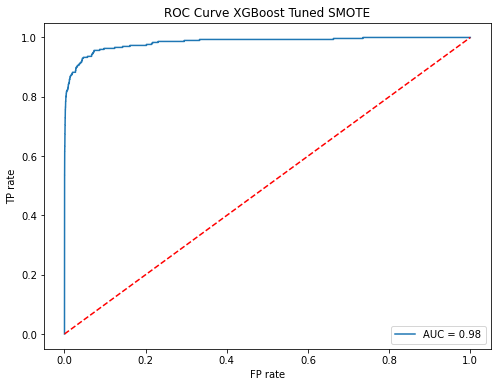

In [17]:
y_pred_x_s = xgb_s.predict_proba(X_test)[:,1]
fp_r, tp_r, t = metrics.roc_curve(y_test, y_pred_x_s)
auc_x_s = metrics.auc(fp_r, tp_r)
plt.figure(figsize=(8, 6))
plt.plot(fp_r, tp_r, label="AUC = %.2f" % auc_x_s)
plt.plot([0,1],[0,1],"r--")
plt.ylabel("TP rate")
plt.xlabel("FP rate")
plt.legend(loc=4)
plt.title("ROC Curve XGBoost Tuned SMOTE")
plt.show()

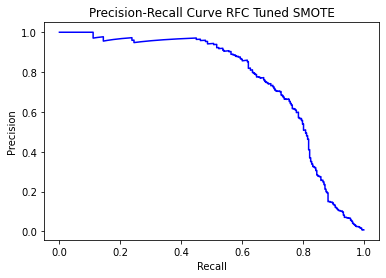

In [18]:
#Precision-recall curve shows the tradeoff between precision and recall for different thresholds.
#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_x_s)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='blue')

#add axis labels to plot
ax.set_title('Precision-Recall Curve RFC Tuned SMOTE')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()

Text(0.5, 1.0, 'XGBoost Feature Importance')

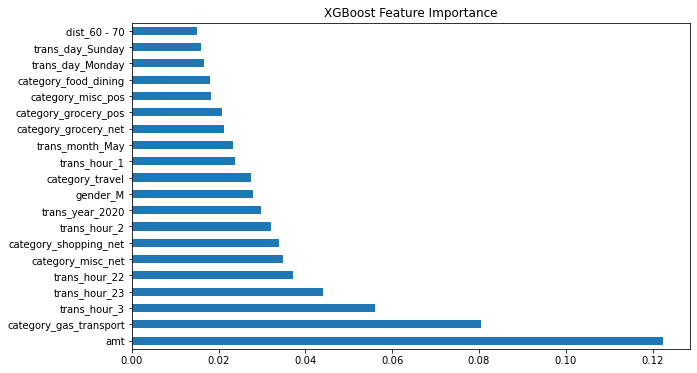

In [84]:
plt.figure(figsize=(10,6))
rfc_f_importances = pd.Series(xgb_s.feature_importances_, index=X1.columns)
rfc_f_importances.nlargest(20).plot(kind='barh')
plt.title("XGBoost Feature Importance")

### XGBoos with RUS

In [85]:
def xgboost_search(X_rus,y_rus, search_verbose=1):
    params = {
    "gamma":[0.5, 1, 1.5, 2, 5],
    "max_depth":[3,4,5,6],
    "min_child_weight": [100],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "learning_rate": [0.1, 0.01, 0.001]
    }
    xgb = XGBClassifier(objective="binary:logistic", eval_metric="auc", use_label_encoder=False)

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    grid_search = GridSearchCV(estimator=xgb, param_grid=params, scoring="roc_auc", n_jobs=1, 
                               cv=skf.split(X_rus,y_rus), verbose=search_verbose)

    grid_search.fit(X_rus,y_rus)

    print(f'Best estimator:\n{grid_search.best_estimator_}')
    print("Parameters: ", grid_search.best_params_)
    print("Highest AUC: %.2f" % grid_search.best_score_)

    return grid_search.best_params_

In [86]:
model_params = xgboost_search(X_rus, y_rus)

Fitting 3 folds for each of 540 candidates, totalling 1620 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6,
              enable_categorical=False, eval_metric='auc', gamma=0.5, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.001, max_delta_step=0, max_depth=3,
              min_child_weight=100, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1.0, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)
Parameters:  {'colsample_bytree': 0.6, 'gamma': 0.5, 'learning_rate': 0.001, 'max_depth': 3, 'min_child_weight': 100, 'subsample': 1.0}
Highest AUC: 0.85


[Parallel(n_jobs=1)]: Done 1620 out of 1620 | elapsed:  2.8min finished


In [87]:
xgb_r = XGBClassifier(objective="binary:logistic", eval_metric="auc", use_label_encoder=False)
xgb_r.set_params(**model_params)
xgb_r.fit(X_rus, y_rus)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6,
              enable_categorical=False, eval_metric='auc', gamma=0.5, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.001, max_delta_step=0, max_depth=3,
              min_child_weight=100, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1.0, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [88]:
pred_xgb_r = xgb_r.predict(X_rus)
pred_xgb_test_r = xgb_r.predict(X_test)
print('Accuracy Train Score:', accuracy_score(y_rus, pred_xgb_r))
print('Accuracy Test Score:', accuracy_score(y_test, pred_xgb_test_r))
print('5 Cross val score:', cross_val_score(xgb_r, X_rus, y_rus, cv=5))
print('Cross val score:', cross_val_score(xgb_r, X_rus, y_rus, cv=5).mean())

Accuracy Train Score: 0.8757183908045977
Accuracy Test Score: 0.9695350176347801
5 Cross val score: [0.85663082 0.88172043 0.89208633 0.87769784 0.86330935]
Cross val score: 0.8742889559320286


In [89]:
print(f'Confusion Matrix:\n{confusion_matrix(y_rus, pred_xgb_r)}')
print(f'Classification Report:\n{ classification_report(y_rus, pred_xgb_r)}')

Confusion Matrix:
[[677  19]
 [154 542]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.97      0.89       696
           1       0.97      0.78      0.86       696

    accuracy                           0.88      1392
   macro avg       0.89      0.88      0.87      1392
weighted avg       0.89      0.88      0.87      1392



In [90]:
print(f'Confusion Matrix:\n{confusion_matrix(y_test, pred_xgb_test_r)}')
print(f'Classification Report:\n{ classification_report(y_test, pred_xgb_test_r)}')

Confusion Matrix:
[[53660  1614]
 [   79   219]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     55274
           1       0.12      0.73      0.21       298

    accuracy                           0.97     55572
   macro avg       0.56      0.85      0.60     55572
weighted avg       0.99      0.97      0.98     55572



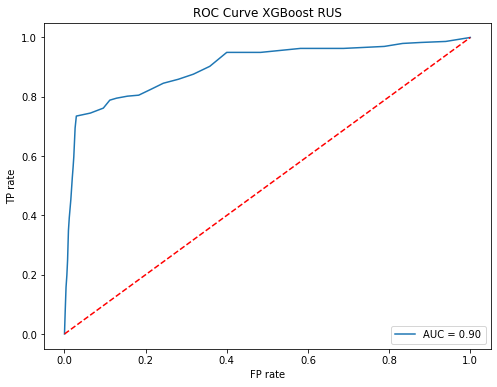

In [91]:
y_pred_x_r = xgb_r.predict_proba(X_test)[:,1]
fp_r, tp_r, t = metrics.roc_curve(y_test, y_pred_x_r)
auc_x_r = metrics.auc(fp_r, tp_r)
plt.figure(figsize=(8, 6))
plt.plot(fp_r, tp_r, label="AUC = %.2f" % auc_x_r)
plt.plot([0,1],[0,1],"r--")
plt.ylabel("TP rate")
plt.xlabel("FP rate")
plt.legend(loc=4)
plt.title("ROC Curve XGBoost RUS")
plt.show()

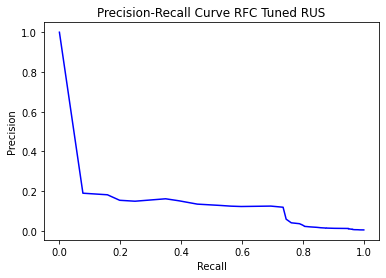

In [92]:
#Precision-recall curve shows the tradeoff between precision and recall for different thresholds.
#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_x_r)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='blue')

#add axis labels to plot
ax.set_title('Precision-Recall Curve RFC Tuned RUS')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()


========================== Model Test Results ========================

=== Random Forest SMOTE ===
Model Accuracy:  97.5%

Recall:
 1.646153846153846


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     55274
           1       0.14      0.72      0.24       298

    accuracy                           0.98     55572
   macro avg       0.57      0.85      0.61     55572
weighted avg       0.99      0.98      0.98     55572


=== Random Forest SMOTE Tuned ===
Model Accuracy:  99.7%

Recall:
 0.8538461538461538


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     55274
           1       0.95      0.37      0.53       298

    accuracy                           1.00     55572
   macro avg       0.97      0.69      0.77     55572
weighted avg       1.00      1.00      1.00     55572


=== XGBoost SMOTE Tuned ===
Model Accuracy:  99.6%

Re

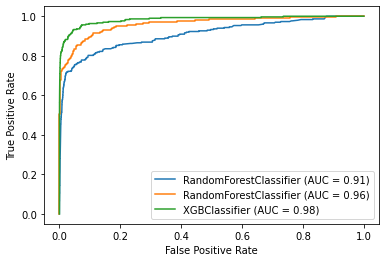

In [93]:
classdict = {'normal':0, 'fraudulent':1}
print()
print('========================== Model Test Results ========================' "\n")   
modlist = [('Random Forest SMOTE', rfc_s),
           ('Random Forest SMOTE Tuned', rfc_b_s),
          ('XGBoost SMOTE Tuned', xgb_s)]
           
           
           
models = [j for j in modlist]
for i, v in models:
    accuracy = metrics.accuracy_score(y_test, v.predict(X_test))
    confusion_matrix = metrics.confusion_matrix(y_test, v.predict(X_test))
    classification = metrics.classification_report(y_test, v.predict(X_test))   
    print('=== {} ==='.format(i))
    print ("Model Accuracy: ",  '{}%'.format(np.round(accuracy, 3) * 100))
    print()
    print("Recall:" "\n", confusion_matrix[1][1]/130)
    print()
    #pf.plot_confusion_matrix(confusion_matrix, classes = list(classdict.keys()),title='Confusion Matrix Plot', cmap=plt.cm.summer)
    print() 
    print("Classification Report:" "\n", classification) 
    print()
    print("Confusion Matrix:" "\n", confusion_matrix)
    print()

print('============================= ROC Curve ===============================' "\n")      
classifiers = [rfc_s, rfc_b_s, xgb_s]
ax = plt.gca()
for i in classifiers:
    metrics.plot_roc_curve(i, X_test, y_test, ax=ax)

In [94]:
xgb_s.save_model("smote_fraud_tuned.xgb")

#### Conclusion: The best model for credit card fraud detection using supervised models is XGBoost Classifier with optimal parameters and  imbalance technique SMOTE founded  227 fraud cases from 298 but missed 71 fraud cases and only 131 identified as fraud but it's not. Other model wich work better for financial organization is Random Forest with optimal parameters and RUS technique founded  276 fraud cases from 298 and only 22 was recognized as not fraud but it's fraud but 2,490 False Positive. In the next notebook I will use unsupervised learning such as clustering and anomaly detection. 